In [1]:
import tensornetwork as tn
import tensorflow as tf
import qriemannopt as qro
from MERAOpt import MERAOpt
import matplotlib.pyplot as plt
from tqdm import tqdm
tn.set_default_backend("tensorflow")

In [2]:
@tf.function
def mera_layer(H,
               U,
               U_conj,
               Z_left,
               Z_right,
               Z_left_conj,
               Z_right_conj):
    
    # U and Z reshaping
    chi = tf.cast(tf.math.sqrt(tf.cast(U.shape[0], dtype=tf.float64)), dtype=tf.int32)
    chi_new = Z_left.shape[-1]
    
    # tn nodes
    h = tn.Node(tf.reshape(H, (chi, chi, chi, chi)))
    u = tn.Node(tf.reshape(U, (chi, chi, chi, chi)))
    u_conj = tn.Node(tf.reshape(U_conj, (chi, chi, chi, chi)))
    z_left = tn.Node(tf.reshape(Z_left, (chi, chi, chi, chi_new)))
    z_right = tn.Node(tf.reshape(Z_right, (chi, chi, chi, chi_new)))
    z_left_conj = tn.Node(tf.reshape(Z_left_conj, (chi, chi, chi, chi_new)))
    z_right_conj = tn.Node(tf.reshape(Z_right_conj, (chi, chi, chi, chi_new)))
    
    # standart for all part
    z_left[0]^z_left_conj[0]
    z_right[2]^z_right_conj[2]
    u[2]^z_left[2]
    u[3]^z_right[0]
    u_conj[2]^z_left_conj[2]
    u_conj[3]^z_right_conj[0]
    
    # first renormalization
    z_left[1]^h[2]
    z_left_conj[1]^h[0]
    u[0]^h[3]
    u_conj[0]^h[1]
    u[1]^u_conj[1]
    z_right[1]^z_right_conj[1]
    nodes = tn.reachable(h)
    renorm_first = tn.contractors.optimal(nodes, [z_left_conj[3],
                                                  z_right_conj[3],
                                                  z_left[3],
                                                  z_right[3]])
    
    # standart for all part
    z_left[0]^z_left_conj[0]
    z_right[2]^z_right_conj[2]
    u[2]^z_left[2]
    u[3]^z_right[0]
    u_conj[2]^z_left_conj[2]
    u_conj[3]^z_right_conj[0]
    
    # second renormalization
    z_left[1]^z_left_conj[1]
    z_right[1]^z_right_conj[1]
    u[0]^h[2]
    u[1]^h[3]
    u_conj[0]^h[0]
    u_conj[1]^h[1]
    nodes = tn.reachable(h)
    renorm_second = tn.contractors.optimal(nodes, [z_left_conj[3],
                                                  z_right_conj[3],
                                                  z_left[3],
                                                  z_right[3]])
    
    # standart for all part
    z_left[0]^z_left_conj[0]
    z_right[2]^z_right_conj[2]
    u[2]^z_left[2]
    u[3]^z_right[0]
    u_conj[2]^z_left_conj[2]
    u_conj[3]^z_right_conj[0]
    
    # third renormalization
    z_left[1]^z_left_conj[1]
    u[0]^u_conj[0]
    u[1]^h[2]
    u_conj[1]^h[0]
    z_right[1]^h[3]
    z_right_conj[1]^h[1]
    nodes = tn.reachable(h)
    renorm_third = tn.contractors.optimal(nodes, [z_left_conj[3],
                                                  z_right_conj[3],
                                                  z_left[3],
                                                  z_right[3]])
    
    return (renorm_first.tensor + renorm_second.tensor + renorm_third.tensor) / 3

@tf.function
def z_gen(inp, out):
    
    Z = qro.manifold.real_to_complex(tf.random.normal((inp ** 3, inp ** 3, 2), dtype=tf.float64))
    Z, _ = tf.linalg.qr(Z)
    return Z[:, :out]


@tf.function
def u_gen(dim):
    
    U = tf.eye(dim ** 2, dtype=tf.complex128)
    return U

In [3]:
#===========================================#
max_chi = 8 # max bond dim
num_of_layers = 5 # number of layers of MERA
h_x = 1. # transvers field
#===========================================#

# pauli matrices
sigma = tf.constant([[[1j*0, 1 + 1j*0], [1 + 1j*0, 0*1j]],
                    [[0*1j, -1j], [1j, 0*1j]],
                    [[1 + 0*1j, 0*1j], [0*1j, -1 + 0*1j]]],dtype=tf.complex128)
    
# hamiltonian
h = -tf.einsum('ij,kl->ikjl', sigma[2], sigma[2]) +\
tf.einsum('ij,kl->ikjl', -h_x * sigma[0] / 2, tf.eye(2, dtype=tf.complex128)) +\
tf.einsum('ij,kl->ikjl', -tf.eye(2, dtype=tf.complex128), h_x * sigma[0] / 2)

# random unitary and isometyric matrices
U = u_gen(2)
Z = z_gen(2, max_chi)
U_list = [u_gen(max_chi) for _ in range(num_of_layers - 1)]
Z_list = [z_gen(max_chi, max_chi) for _ in range(num_of_layers - 1)]
U_list = [U] + U_list
Z_list = [Z] + Z_list
psi = qro.manifold.real_to_complex(tf.random.normal((max_chi ** 2, 1, 2), dtype=tf.float64))
psi, _ = tf.linalg.qr(psi)

# real U, Z, psi
U_list = [qro.manifold.complex_to_real(U_list[i]) for i in range(len(U_list))]
Z_list = [qro.manifold.complex_to_real(Z_list[i]) for i in range(len(Z_list))]
psi = qro.manifold.complex_to_real(psi)

In [4]:
#========================#
iters = 3000 # number of iterations
lr_i = 0.1
lr_f = 0.1
#========================#

decay = (lr_f / lr_i) ** (1 / iters)

# making hamiltonian negative defenite
'''local_energy = 3 * tf.cast(tf.linalg.eigvalsh(tf.reshape(h, (4, 4)))[-1], dtype=tf.float64)
h = h - tf.cast(local_energy, dtype=tf.complex128) * tf.reshape(tf.eye(4, dtype=tf.complex128), (2, 2, 2, 2))'''

# optimizers
m = qro.manifold.StiefelManifold() # Stiefel manifold
opt = qro.optimizers.RAdam(m, lr_i)

list_of_E = []
varU = [tf.Variable(U_re) for U_re in U_list]
varZ = [tf.Variable(Z_re) for Z_re in Z_list]
varpsi = tf.Variable(psi)
all_vars = varU + varZ + [varpsi]

for j in tqdm(range(iters)):

    # gradient calculation
    with tf.GradientTape() as tape:

        # complex matrices
        varU_c = [qro.manifold.real_to_complex(varU[i]) for i in range(len(varU))]
        varZ_c = [qro.manifold.real_to_complex(varZ[i]) for i in range(len(varZ))]
        varpsi_c = qro.manifold.real_to_complex(varpsi)

        h_renorm = h
        # applying renormalization
        for i in range(len(varU)):
            h_renorm = mera_layer(h_renorm,
                                  varU_c[i],
                                  tf.math.conj(varU_c[i]),
                                  varZ_c[i],
                                  varZ_c[i],
                                  tf.math.conj(varZ_c[i]),
                                  tf.math.conj(varZ_c[i]))
        # renormalizad hamiltonian
        h_renorm = tf.reshape(h_renorm, (max_chi * max_chi, max_chi * max_chi))
        # energy
        E = tf.cast((tf.transpose(tf.math.conj(varpsi_c)) @ h_renorm @ varpsi_c),
                    dtype=tf.float64)[0, 0]
        # adding curent value of energy
        list_of_E.append(E)

    # real gradients
    grad = tape.gradient(E, all_vars)
    opt.apply_gradients(zip(grad, all_vars))
    opt._set_hyper("learning_rate", opt._get_hyper("learning_rate") * decay)

  0%|                                                                                         | 0/3000 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [03:14<00:00, 15.46it/s]


tf.Tensor(-1.2763499825270697, shape=(), dtype=float64)
-1.2748570272966506


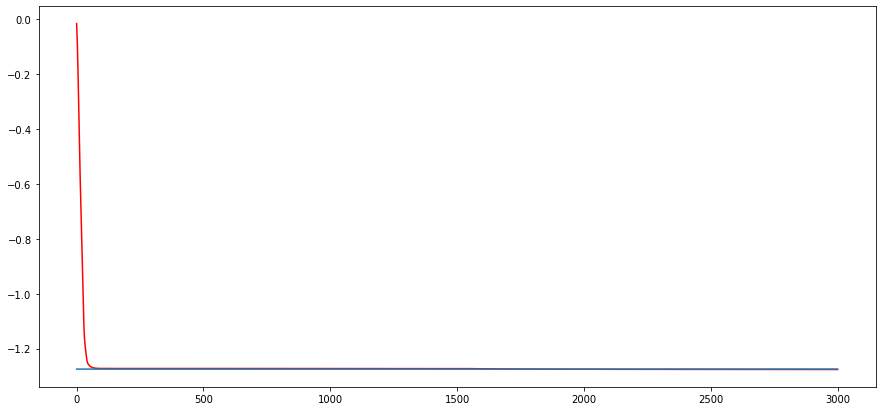

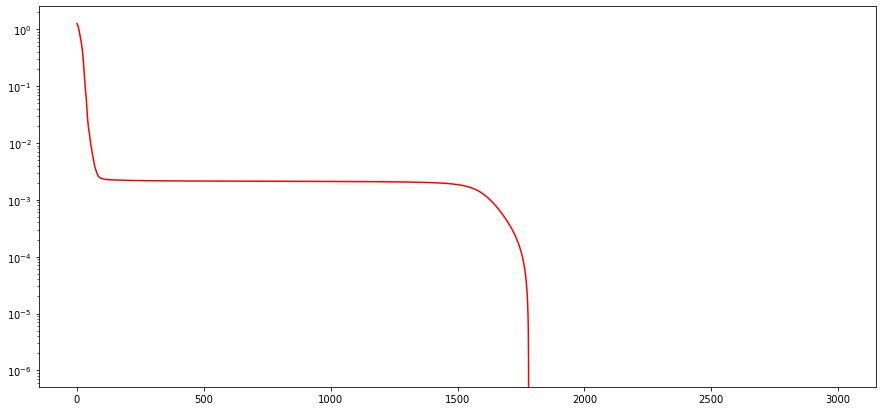

In [5]:
import numpy as np
from scipy import integrate
# exact value of energy in critical point
N = 2 * (num_of_layers ** 2)
E0_exact_fin = -2 * (1 / np.sin(np.pi / (2 * N))) / N

g = h_x
f = lambda k,g : -2*np.sqrt(1+g**2-2*g*np.cos(k))/np.pi/2.
E0_exact = integrate.quad(f, 0, np.pi, args=(g,))[0]

plt.figure(figsize=(15, 7))
plt.plot(list_of_E, 'r')
plt.plot([E0_exact_fin] * len(list_of_E))
plt.figure(figsize=(15, 7))
plt.yscale('log')
plt.plot(list_of_E - tf.convert_to_tensor(([E0_exact_fin] * len(list_of_E))), 'r')
print(list_of_E[-1])
print(E0_exact_fin)
plt.savefig('MERAOpt_vs_Radam.pdf')

In [39]:
nodes = tn.reachable(U_node)
result = tn.contractors.optimal(nodes, [U_node[0], U_node[1], Uh_node[0], Uh_node[1]])

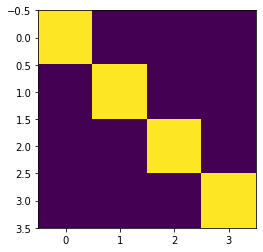

In [42]:
plt.imshow(tf.math.real(tf.reshape(result.tensor, (4, 4))))

In [64]:
tf.linalg.adjoint(varpsi_c) @ varpsi_c

<tf.Tensor: id=3811286, shape=(1, 1), dtype=complex128, numpy=array([[1.-3.24646631e-18j]])>

In [56]:
tf.cast(tf.linalg.eigvalsh(tf.reshape(h, (4, 4)))[0], dtype=tf.float64)

<tf.Tensor: id=681, shape=(), dtype=float64, numpy=-1.4142135623730947>

In [277]:
opt._get_hyper("learning_rate")

<tf.Variable 'RAdam/learning_rate:0' shape=() dtype=float32, numpy=0.1>

In [62]:
uu = z_gen(6, 6)

In [66]:
uu = qro.manifold.real_to_complex(varZ[1])

In [70]:
tf.transpose(tf.math.conj(uu)) @ uu

<tf.Tensor: id=3811298, shape=(6, 6), dtype=complex128, numpy=
array([[ 1.00000000e+00-1.07196265e-18j,  3.96328435e-16+9.85167078e-17j,
         1.62976457e-18+9.70785947e-17j, -3.76659354e-16-7.93744051e-17j,
         2.57725998e-16-1.06529497e-16j,  5.10474472e-16+8.58958248e-17j],
       [ 3.96328435e-16-1.00873998e-16j,  1.00000000e+00-1.74252077e-18j,
        -5.63749617e-16-1.66699808e-17j, -1.71879566e-16-2.43675715e-16j,
         1.28663069e-16+2.40978605e-16j, -4.15158665e-16-5.72365675e-18j],
       [ 1.62976457e-18-8.89430817e-17j, -5.63749617e-16+1.92311438e-17j,
         1.00000000e+00+2.50458505e-18j,  7.45219590e-17+6.08508839e-17j,
         2.23061290e-17+3.25967511e-17j, -5.50876418e-17-2.61028482e-16j],
       [-3.76659354e-16+7.29198465e-17j, -1.71879566e-16+2.41912116e-16j,
         7.45219590e-17-7.59157208e-17j,  1.00000000e+00+2.05385262e-18j,
        -2.23312584e-16+2.08677556e-16j,  3.91769146e-16+2.68429662e-16j],
       [ 2.57725998e-16+1.06442304e-16j,  1.2

In [32]:
uu

<tf.Tensor: id=1403, shape=(216, 6), dtype=complex128, numpy=
array([[-0.08083964+0.00474232j,  0.0013591 +0.07577601j,
        -0.0352519 +0.0378259j , -0.02618614+0.08423254j,
         0.04251903+0.0026539j , -0.04382455-0.02890851j],
       [ 0.0460774 -0.05859537j, -0.04059878-0.07533729j,
        -0.06373458+0.03396579j, -0.14013817-0.07149078j,
         0.09562784-0.02914726j,  0.03589254+0.0100963j ],
       [ 0.04743737-0.00643065j,  0.00178544-0.02845281j,
        -0.03396882-0.00553861j, -0.06514307+0.00059873j,
        -0.07014545+0.03877267j, -0.0616828 +0.03762642j],
       ...,
       [ 0.04793311+0.03785272j, -0.01089563-0.13137677j,
         0.00546395-0.00117565j,  0.10713058-0.00557486j,
        -0.07657147+0.05887103j, -0.05129739+0.04821661j],
       [-0.00824435-0.06580202j,  0.03314921-0.04865514j,
         0.00114549-0.09130664j, -0.00684185+0.00616283j,
        -0.03359384-0.03393194j,  0.09986385+0.00399015j],
       [ 0.02385369+0.06033197j,  0.0219259 -0.0378

In [27]:
Z = z_gen(3, 3)

In [28]:
tf.linalg.adjoint(Z) @ Z

<tf.Tensor: id=1402, shape=(3, 3), dtype=complex128, numpy=
array([[ 1.00000000e+00-3.94933179e-18j,  3.38643562e-17-5.41084856e-18j,
        -4.95170630e-17+4.36790795e-18j],
       [ 3.38643562e-17+1.31541402e-17j,  1.00000000e+00-4.31339937e-18j,
         6.32760251e-18+3.11677530e-17j],
       [-4.95170630e-17-2.04239679e-17j,  6.32760251e-18-5.17538841e-17j,
         1.00000000e+00-3.59209144e-18j]])>

In [39]:
test = tf.Variable(qro.manifold.real_to_complex(tf.random.uniform((90, 3, 2), dtype=tf.float64)))

In [40]:
test

<tf.Variable 'Variable:0' shape=(90, 3) dtype=complex128, numpy=
array([[0.3564078 +0.29371301j, 0.30304522+0.94636057j,
        0.70540978+0.25284123j],
       [0.32928069+0.06571905j, 0.00533283+0.51523618j,
        0.90821711+0.3544367j ],
       [0.4877937 +0.23451013j, 0.78902453+0.33149053j,
        0.32019163+0.28913061j],
       [0.7311989 +0.64339621j, 0.09127563+0.48935399j,
        0.14342663+0.97433062j],
       [0.9296472 +0.79821899j, 0.05114315+0.25564923j,
        0.5016446 +0.44079255j],
       [0.27897221+0.60653959j, 0.74559858+0.79887385j,
        0.60137575+0.81345225j],
       [0.49102755+0.81464244j, 0.91979676+0.43409442j,
        0.99897974+0.15268521j],
       [0.41979282+0.78388308j, 0.74496977+0.21873646j,
        0.17804994+0.57461482j],
       [0.68777651+0.42992189j, 0.02102355+0.18453498j,
        0.31590651+0.02225175j],
       [0.00568088+0.60095242j, 0.01029205+0.9576547j ,
        0.81549495+0.49281783j],
       [0.78087084+0.80435166j, 0.66702991+0.

In [41]:
tf.linalg.adjoint(test)

<tf.Tensor: id=1473, shape=(3, 90), dtype=complex128, numpy=
array([[0.3564078 -0.29371301j, 0.32928069-0.06571905j,
        0.4877937 -0.23451013j, 0.7311989 -0.64339621j,
        0.9296472 -0.79821899j, 0.27897221-0.60653959j,
        0.49102755-0.81464244j, 0.41979282-0.78388308j,
        0.68777651-0.42992189j, 0.00568088-0.60095242j,
        0.78087084-0.80435166j, 0.02998689-0.53624396j,
        0.7529409 -0.70382261j, 0.9520647 -0.7596783j ,
        0.77640242-0.53140157j, 0.59269364-0.44548378j,
        0.58276302-0.70474837j, 0.90403965-0.76844021j,
        0.05292333-0.54342692j, 0.41782031-0.68233151j,
        0.13827321-0.85323868j, 0.94226043-0.99892875j,
        0.65368213-0.2951797j , 0.15753062-0.54323154j,
        0.79202258-0.05488707j, 0.33304875-0.71422311j,
        0.91786937-0.36725831j, 0.02603222-0.69004641j,
        0.49183297-0.41599286j, 0.77210764-0.95946516j,
        0.84008241-0.31818375j, 0.99849074-0.7189233j ,
        0.38485819-0.19161568j, 0.99215771-